In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage import io
import random
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from tqdm.notebook import tqdm
from IPython import display
import sys

import cv2

In [2]:
class Leafs(Dataset):
    def __init__(self, data_dir, transform=None, num=350):
        super(Leafs, self).__init__()

  
        self.img = []
        self.labels = []
        for j, l in enumerate(['train_health', 'img_rust', 'img_scab', 'img_both']):
            d = os.path.join(data_dir, l)
            names = sorted(os.listdir(d))[:num]
            
            self.img += [os.path.join(d, n) for n in names if not n.startswith('.')]
            self.labels += [j] * len(names)
    
        self.transform = transform
 

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):

        img = Image.open(self.img[idx])
        seed = np.random.randint(0,2**32)
        if self.transform != None:
            random.seed(seed)
            img = self.transform(img)
        return img, self.labels[idx]


In [3]:
train_transform = transforms.Compose([
        #transforms.Resize((344, 512), interpolation = 0),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])
test_transform = transforms.Compose([
        transforms.Resize((344, 512)),
        transforms.ToTensor(),
    ])



dataset= Leafs('./data/leafs_small/', 
                    train_transform)


In [ ]:
# for old_path in tqdm(dataset.img):
#     img = Image.open(old_path)
#     img_small = img.resize((512, 341))
#     new_path = 'leafs_small'.join(old_path.split('leafs'))
    
#     img_small.save(new_path)

In [4]:
train_num = len(dataset)*4//5
test_num = len(dataset) - train_num

train_set, val_set = torch.utils.data.random_split(dataset, [train_num, test_num])
train_dataloader = DataLoader(train_set,batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=128, shuffle=False)

In [5]:
torch.cuda.empty_cache()
device = torch.device('cuda:0')

In [6]:
class CAM(nn.Module):
    def __init__(self):
        super(CAM, self).__init__()
        self.net = torchvision.models.resnet18(pretrained=True)
        self.net.fc = nn.Linear(in_features=512, out_features=4, bias=False)
    
    def forward(self, x):
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x = self.net.maxpool(x)

        x = self.net.layer1(x)
        x = self.net.layer2(x)
        x = self.net.layer3(x)
        x = self.net.layer4(x)
        conv_features = x
        x = self.net.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.net.fc(x)

        return conv_features, x

In [7]:
inp = torch.randn(10, 3, 256, 256).to(device)
net = CAM().to(device)

In [8]:
n_epocs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=0.1)
sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epocs)

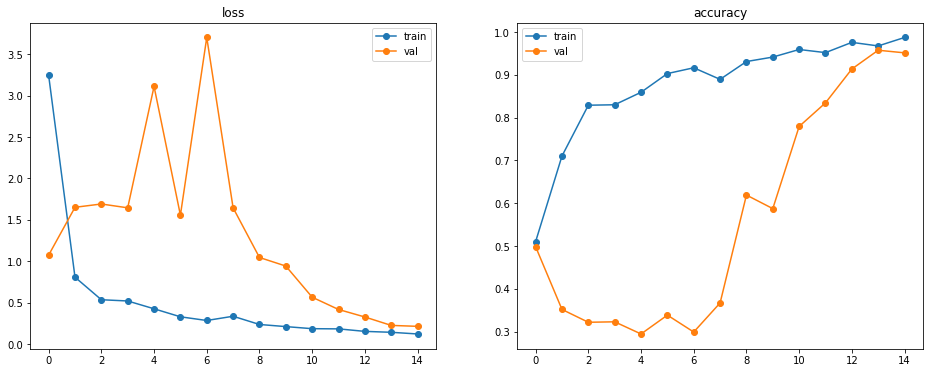

In [9]:
losses_train = []
accs_train = []

losses_val = []
accs_val = []

for i in range(n_epocs):
    net.train()
    losses = []
    accs = []
    for img, label in tqdm(train_dataloader):
        _, out = net(img.to(device))
        loss = loss_fn(out, label.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accs.append((out.argmax(1) == label.to(device)).float().mean().item())
        losses.append(loss.item())
    accs_train.append(np.mean(accs))
    losses_train.append(np.mean(losses))
    sheduler.step()    
    
    net.eval()
    losses = []
    accs = []
    for img, label in tqdm(val_dataloader):
        with torch.no_grad():
            _, out = net(img.to(device))
        loss = loss_fn(out, label.to(device))

        accs.append((out.argmax(1) == label.to(device)).float().mean().item())
        losses.append(loss.item())
    accs_val.append(np.mean(accs))
    losses_val.append(np.mean(losses))

    
    display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax[0].set_title('loss')
    ax[0].plot(losses_train, '-o')
    ax[0].plot(losses_val, '-o')
    ax[0].legend(['train', 'val'])

    ax[1].set_title('accuracy')
    ax[1].plot(accs_train, '-o')
    ax[1].plot(accs_val, '-o')
    ax[1].legend(['train', 'val'])
    plt.show()

In [10]:
torch.save(net.state_dict(), './model.pth')

## Class activation maps

In [9]:
net = CAM().to(device)
net.load_state_dict(torch.load('model.pth'))
net.eval();

In [132]:
n = 7
inp, label = val_set[n]
img = inp.permute(1,2,0).numpy()
inp = inp[None].to(device)

conv, out = net(inp)
print(label)

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


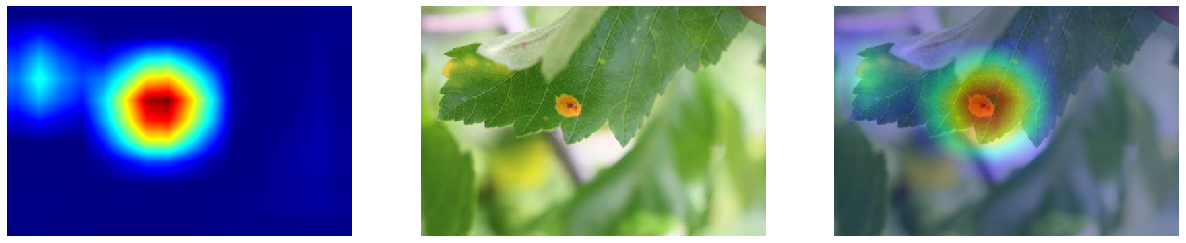

In [133]:

cam = (net.net.fc.weight[label][:,None, None].abs() * conv[0].abs()).sum(0)
#cam = (net.net.fc.weight[label][:,None, None] * conv[0]).sum(0)
cam = cam.data.cpu().numpy()
cam -= cam.min()
cam /= cam.max()
cam = (cam * 255).astype(np.uint8)
h, w, _ = img.shape
cam = cv2.resize(cam, (w,h))

heatmap = (cv2.applyColorMap(cam, cv2.COLORMAP_JET) / 255)[:,:,::-1]
result = heatmap * 0.4 + img * 0.6

fig, ax = plt.subplots(1, 3, figsize=(21,7))
ax[0].imshow(heatmap)
ax[0].axis('off')
ax[1].imshow(inp[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[2].imshow(result)
ax[2].axis('off')
plt.show()

# Process video

In [8]:
torch.cuda.empty_cache()

In [9]:
net = CAM().to(device)
net.load_state_dict(torch.load('model.pth'))
net.eval();

In [13]:
class Frames(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.ids = list(range(3000, 4500+1))
        #self.n = len(os.listdir(path))
        self.transform = transform
    
    def __len__(self):
        #return self.n
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.path, '{}.jpg'.format(self.ids[idx]))
        img = Image.open(img_path)
        img = self.transform(img)
        return img

In [14]:
dataset = Frames('./video_youtube/', test_transform)
dataset.n = 1001
bs = 32
dataloader = DataLoader(dataset, batch_size=bs)

In [21]:
label = 2
for j, inp in tqdm(enumerate(dataloader)):
    with torch.no_grad():
        conv, out = net(inp.to(device))
        for i in range(len(out)):
            #cam = (net.net.fc.weight[label][:,None, None] * conv[i]).sum(0)
            cam = (net.net.fc.weight[label][:,None, None].abs() * conv[i].abs()).sum(0)
            cam = cam.data.cpu().numpy()
            cam -= cam.min()
            cam /= cam.max()
            cam = (cam * 255).astype(np.uint8)
            #h, w, _ = img.shape
            h ,w = 344, 512
            cam = cv2.resize(cam, (w,h))
            heatmap = (cv2.applyColorMap(cam, cv2.COLORMAP_JET))[:,:,::-1]
#            img_path = './heatmaps3500{}/{}.jpg'.format(label, j*bs + i)
            img_path = './heatmaps3500/{}.jpg'.format(3000 + j*bs + i)
            cv2.imwrite(img_path, heatmap[:,:,::-1].astype(np.uint8))

In [22]:
height, width, layers = 344, 512, 3
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('heatmaps3500.mp4',fourcc,24,(width,height))


heatmap_path = './heatmaps3500/'
frames_path = './video_youtube/'
#for i in tqdm(range(len(os.listdir(heatmap_path))-1)):
for i in tqdm(range(3000,4501)):
    heat_path = os.path.join(heatmap_path, '{}.jpg'.format(i))
    frame_path = os.path.join(frames_path, '{}.jpg'.format(i))
    
    frame = cv2.imread(frame_path)
    frame = cv2.resize(frame, (w, h))
    heat = cv2.imread(heat_path)
    
    res = (heat * 0.4 + frame * 0.6).astype(np.uint8)
    video.write(res)
cv2.destroyAllWindows()
video.release()